# Capstone - Non-Invasive Prediction of Glycemic Events in Type 1 Diabetes 

### About this note book

This notebook uses D1NAMO Data set.

D1NAMO project — aiming to detect glycemic events through non-invasive ECG pattern analysis — this dataset that can be used to help to develop health-care systems based on wearable devices in non-clinical conditions.

you can find the data set here : https://zenodo.org/record/1421616


This notebook divided into three sections:
- Part 1 - *Data files location identification on hard drive*  
- Part 2 - *Patients Data Pre-Processing*
- Part 3 - *Machine Learning Model*

### Part 1 - *Data files location identification on hard drive*

In [9]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
from time import time
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import re
import fnmatch

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [10]:
# files Identifications
#different data files or "signal" files in the data set

signals = ['glucose','Breathing','ECG','Accel','Summary']

In [11]:
dataset_path='/Volumes/Transcend/Capstone/Working Files'

In [12]:
def data_files(dataset_path,patient_number,signal):

    # Changing work directory 
    import os
    os.chdir(dataset_path)

    #creating a list with all data files for all subjects
    files = glob.glob('../D1NAMO/**/*.csv',recursive=True)

    # file path construction
    x = os.path.join('*dia**/'+'00'+str(patient_number)+'/sensor_data/'+'*'+signal+'.csv')
    # check our path
    print (x)
    print ('_______________________________________________________________________________________________________________')
    print('')
    path= [file for file in files if fnmatch.fnmatch(file,x)]
    import pprint
    pprint.pprint (path)

- Check if we call the correct files files

- Call summary files for patient 2 in diabetes subset

In [13]:
data_files(dataset_path,2,signals[-1])

*dia**/002/sensor_data/*Summary.csv
_______________________________________________________________________________________________________________

['../D1NAMO/diabetes_subset/002/sensor_data/2014_10_01-12_35_54/2014_10_01-12_35_54_Summary.csv',
 '../D1NAMO/diabetes_subset/002/sensor_data/2014_10_01-20_29_57/2014_10_01-20_29_57_Summary.csv',
 '../D1NAMO/diabetes_subset/002/sensor_data/2014_10_02-06_44_21/2014_10_02-06_44_21_Summary.csv',
 '../D1NAMO/diabetes_subset/002/sensor_data/2014_10_03-06_33_20/2014_10_03-06_33_20_Summary.csv',
 '../D1NAMO/diabetes_subset/002/sensor_data/2014_10_03-14_06_08/2014_10_03-14_06_08_Summary.csv',
 '../D1NAMO/diabetes_subset/002/sensor_data/2014_10_04-07_01_03/2014_10_04-07_01_03_Summary.csv',
 '../D1NAMO/diabetes_subset/002/sensor_data/2014_10_04-17_43_12/2014_10_04-17_43_12_Summary.csv']


- Now as we check that we are calling the correct data we are ready to move to next step, patient data preprocessing 

### Part 2 - *Patients Data Pre-Processing*

This function takes the patient number and returns a single data frame with all 4 days patient summary data and glucose converting the data and time to a time index.

#### Part 2 - Section 1: consolidating patient data into a single data frame

The function __*Patient_Data(Patient_number)*__ will do this job for us following the steps below:
- Read all Summary data for all patients and adding a number index from 1 to 9 for each of them
- Subsetting the data frame to the selected patient data
- Read glucose data for the patient and convert it the index to time index
- Resample the glucose data to 1 Second step
- Return a single data frame with summary and glucose data resampled on time index

In [21]:
def Patient_Data(Patient_number):   
    
    import warnings
    warnings.filterwarnings("ignore")

    def Summary_readings():    
 
        summary = pd.DataFrame()

        for i in [1,2,3,4,5,6,7,8,9]:
            files = glob.glob('../D1NAMO/**/*.csv',recursive=True)
            x = os.path.join('*dia**/'+'00'+str(i)+'/sensor_data/'+'*'+signals[-1]+'.csv')
            path= [file for file in files if fnmatch.fnmatch(file,x)]

            #read all glucose files for all diabetic subjects
            summ_patient = pd.concat([pd.read_csv(file) for file in path],axis=0)
            summ_patient['patient']=i
            summary = summary.append(summ_patient)

        ## convert the time column to be the index

        summary['Time'] = pd.to_datetime(summary['Time'],format='%d/%m/%Y %H:%M:%S.%f')
        summary['Time'] = summary['Time'].astype('datetime64[s]')
        summary = summary.set_index(summary['Time'])
        summary.drop(columns =['Time'],inplace=True)

        return summary
    
    summary = Summary_readings()    
    summary_patient = summary[summary.patient==Patient_number]
    
    files = glob.glob('../D1NAMO/**/*.csv',recursive=True)
    x = os.path.join('*dia**/'+'**/'+'glucose'+'.csv')

    #read all glucose files for all diabetic subjects
    glucoses = [pd.read_csv(file).drop(['type','comments'],axis=1) for file in files if fnmatch.fnmatch(file,x)]


    #Identify patient by adding a column with subject number staring from 1 to 9
    for i,glu in enumerate(glucoses):
        glu['patient'] = np.ones(glu.shape[0])*(i+1) 

    # glucoses: adding differntiation column
    for glu in glucoses:
        glu['glucose_diff'] = glu.glucose.diff()

    glucose = pd.concat(glucoses,axis = 0 )
    glucose['time'] = glucose.pipe(lambda x : pd.to_datetime(x['date']+' '+x['time']))    
    glucose.drop(columns=['date'],inplace=True)
    glucose['bin_number']= glucose.index
    glucose.index = glucose['time']
    glucose.drop(columns=['time'],inplace=True)
    
    try:
        glucose_patient = glucose.iloc[glucose.reset_index().groupby('patient').groups[Patient_number]].resample('1s').fillna(method='ffill')
    
    except:
        x=glucose[glucose['patient']==Patient_number]
        x1=x[x.index.value_counts()>1].reset_index().drop_duplicates(subset='time', keep='first')
        x1.set_index('time',inplace=True)
        x2=x[x.index.value_counts()<2]
        x3=pd.concat([x2,x1],axis=0,sort=True)
        x3.sort_index(inplace=True)
        glucose_patient = x3.iloc[x3.reset_index().groupby('patient').groups[Patient_number]].resample('1s').fillna(method='ffill')

    the_join= glucose_patient.join(summary_patient,lsuffix='g',rsuffix='s',how='inner')
    
    return the_join

CPU times: user 24 s, sys: 4.92 s, total: 28.9 s
Wall time: 24.1 s


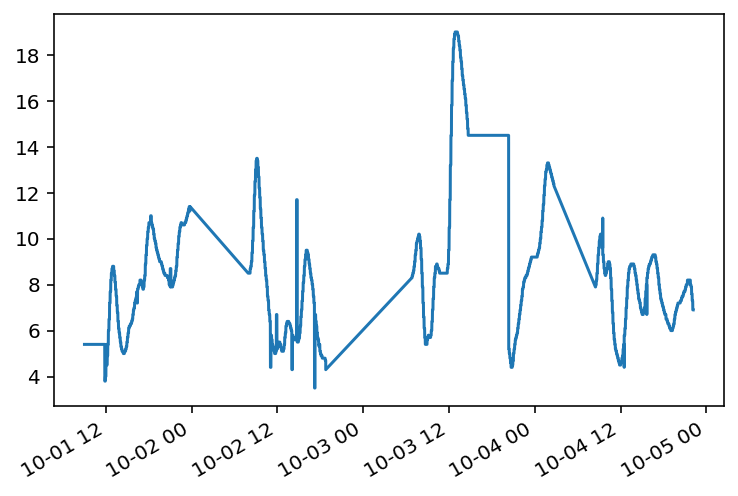

In [22]:
%%time
xx=Patient_Data(7)
xx.glucose.plot()

#### *As we can see, the function returned all our patient summary and glucose data with a time index in a single data frame. Awesome now let's play with it!*

#### Part 2 - Section 2: checking patient data consistency 

one of the main problems that I encourted when i built the model is the result was ver inconsistent across all the patients, consequantly I used the __*daily_glucose(Patient_number, day)*__ function to look at the gloucose reading along the day using four measurment windows:
1. From 12 am to 6 am
2. From 6 am to 12 pm
3. From 12 pm to 6 pm
4. From 6 pm to 12 am

In [23]:
def daily_glucose(Patient_number, day):
    
    p=Patient_Data(Patient_number)
    
    day_times={1:['2014-10-01 00:00:00','2014-10-01 06:00:00','2014-10-01 12:00:00','2014-10-01 18:00:00','2014-10-01 23:59:59'],
               2:['2014-10-02 00:00:00','2014-10-02 06:00:00','2014-10-02 12:00:00','2014-10-02 18:00:00','2014-10-02 23:59:59'],
               3:['2014-10-03 00:00:00','2014-10-03 06:00:00','2014-10-03 12:00:00','2014-10-03 18:00:00','2014-10-03 23:59:59'],
               4:['2014-10-04 00:00:00','2014-10-04 06:00:00','2014-10-04 12:00:00','2014-10-04 18:00:00','2014-10-04 23:59:59']
              }

    
    
    fig, ax = plt.subplots(2,2,figsize=(16,8))

    morning=p.loc[day_times[day][1]:day_times[day][2]]
    y1=morning.glucose
    x1=morning.index
    ax[0,0].plot(x1,y1, color="mediumseagreen")
    ax[0,0].legend()
    ax[0,0].set_title('Morning')

    noon=p.loc[day_times[day][2]:day_times[day][3]]
    y2=noon.glucose.values
    x2=noon.index
    ax[0,1].plot(x2,y2, color="mediumseagreen")
    ax[0,1].legend()
    ax[0,1].set_title('Noon')

    night=p.loc[day_times[day][3]:day_times[day][4]]
    y3=night.glucose.values
    x3=night.index
    ax[1,0].plot(x3,y3, color="mediumseagreen")
    ax[1,0].legend()
    ax[1,0].set_title('Night')

    sleeping=p.loc[day_times[day][0]:day_times[day][1]]
    y4=sleeping.glucose.values
    x4=sleeping.index
    ax[1,1].plot(x4,y4, color="mediumseagreen")
    ax[1,1].legend()
    ax[1,1].set_title('Sleeping')

    plt.show()
    
    return 


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


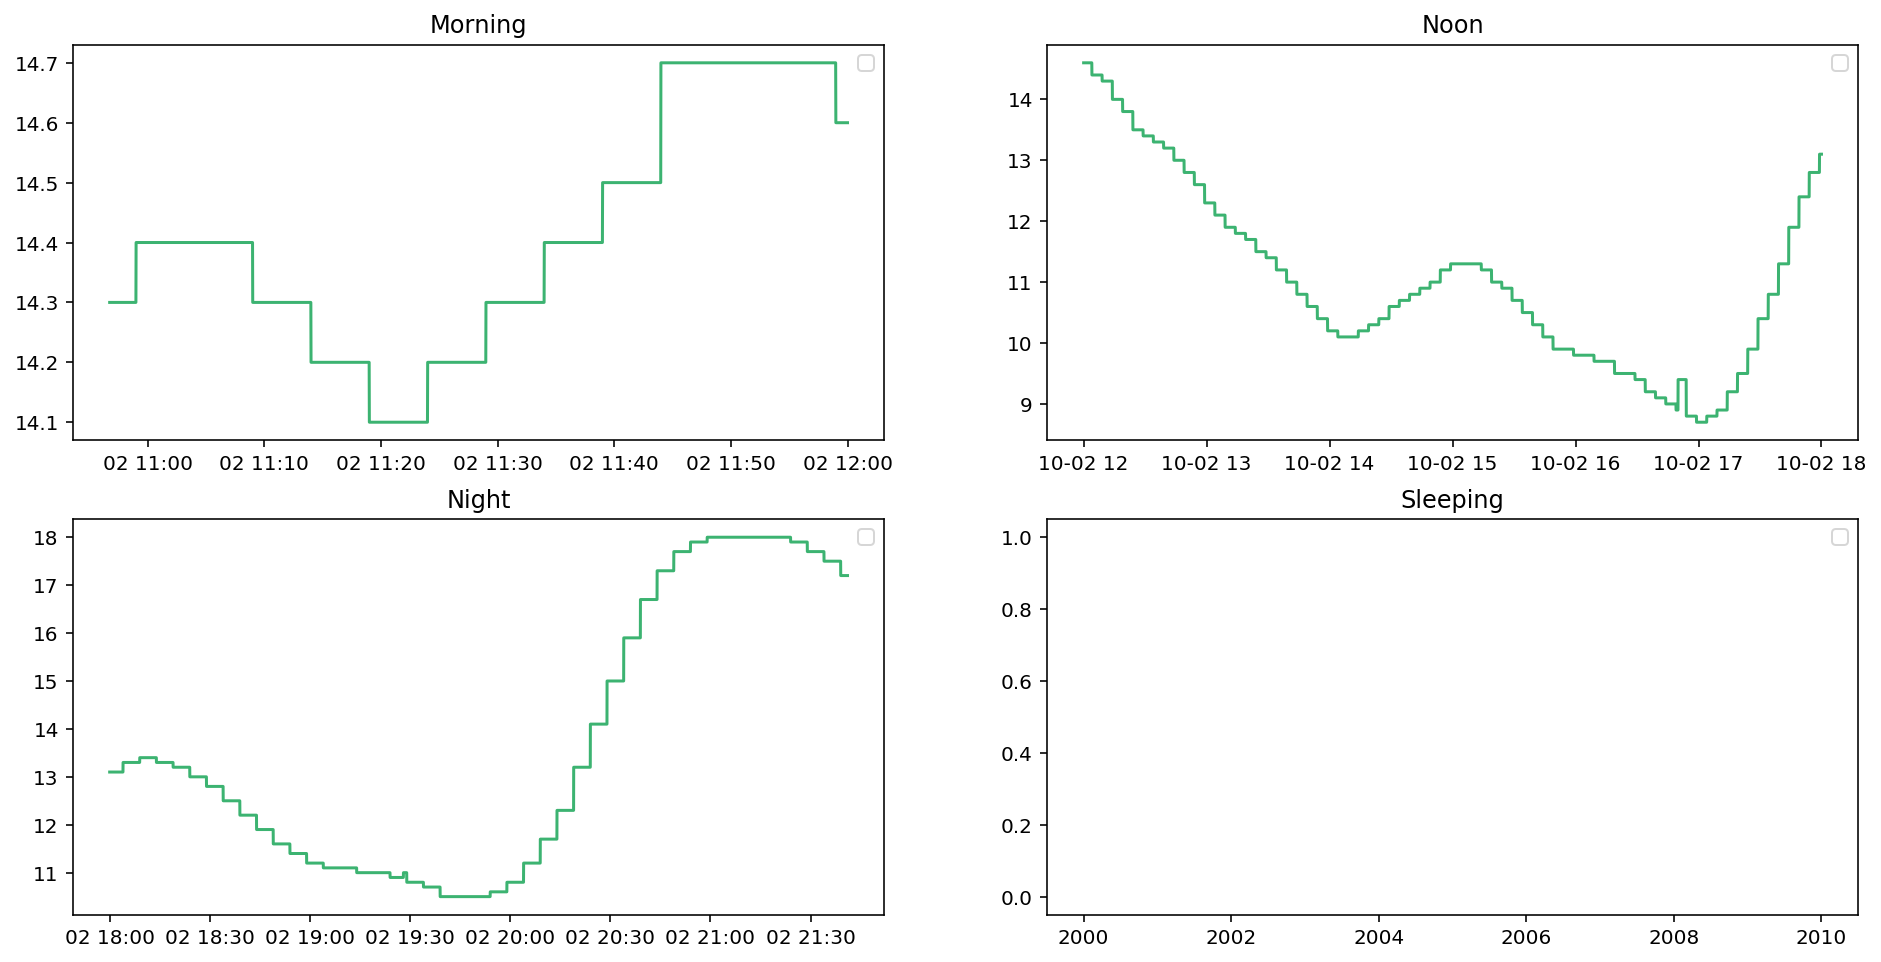

CPU times: user 25.3 s, sys: 5.13 s, total: 30.4 s
Wall time: 24.9 s


In [24]:
%%time
daily_glucose(1,2)

#### From the above results, we can notice the following:
1. We have no data in the period between midnight and the early in the morning
2. We can see the sampling impact on the curve shape. Also, we can notice that there are a few readings in the morning period.

### Part 3 - *Machine Learning Model*

In this part, we feed our data from __*Part 2 - Section 1*__ to a Random Forest __classification model__ that predicts hyperglycemia 5 minutes before the before actually happening.
The main objective is to detect the problem before it happens early; hence, the patient gains more control over diabetes.

#### Part 3 - Section 1:Model to check results for single patient

#### The Model follow the following steps:
1. Use __Patient_Data(Patient Number)__ function to feed data to the model
2. filter BR above 1000
3. Label glucose ('hypo', 'regular', 'hyper') and get dummies.
4. Generate X and y arrays.
5. Split data to train and test using time-series split.
6. Feature Scaling.
7. Feed the scaled data to the Random Forest Model.
8. Get the score and confusion matrix.
9. Rank Feature and drop irrelevant.
10. Plot Results predicted vs actual every cross-validation.

#### Checking Baseline Accuracy 

In [30]:
p=Patient_Data(2)
dummies=pd.get_dummies(pd.cut(p.glucose,[p.glucose.min(),4,8,p.glucose.max()],labels=['hypo','regular','hyper']))
dummies.hyper.value_counts(normalize=True)

0    0.578799
1    0.421201
Name: hyper, dtype: float64

TRAIN: [    0     1     2 ... 23860 23861 23862] TEST: [23863 23864 23865 ... 47719 47720 47721]


<Figure size 432x288 with 0 Axes>

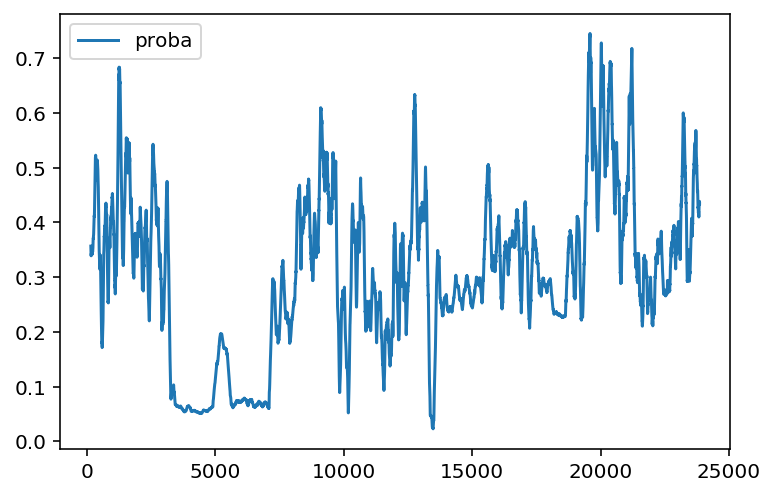

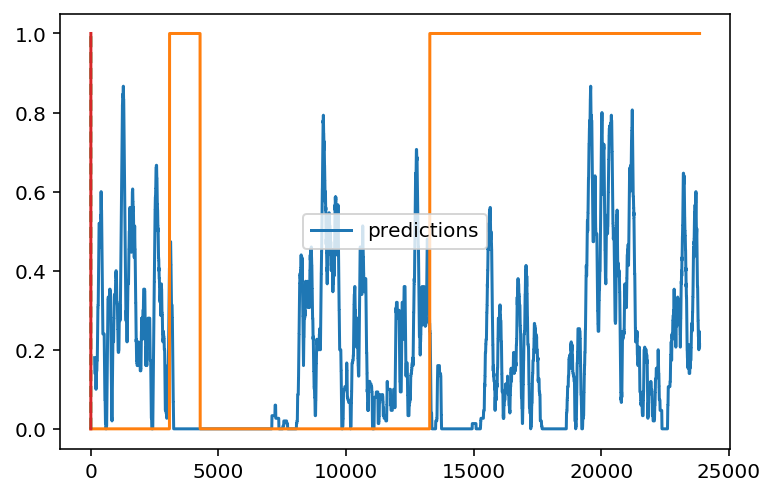


array([[9789, 2293],
       [9692, 2085]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy  \
0  0.292374  0.275507  0.204049  0.120653  0.107417        0.0  0.497674   

   true_negative  true_positive  false_positive  false_negative  
0           9789           2085            2293            9692  
TRAIN: [    0     1     2 ... 47719 47720 47721] TEST: [47722 47723 47724 ... 71578 71579 71580]


<Figure size 432x288 with 0 Axes>

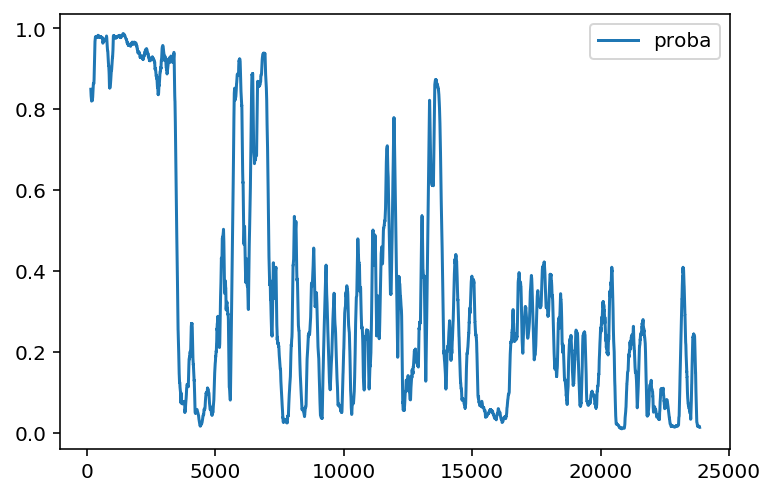

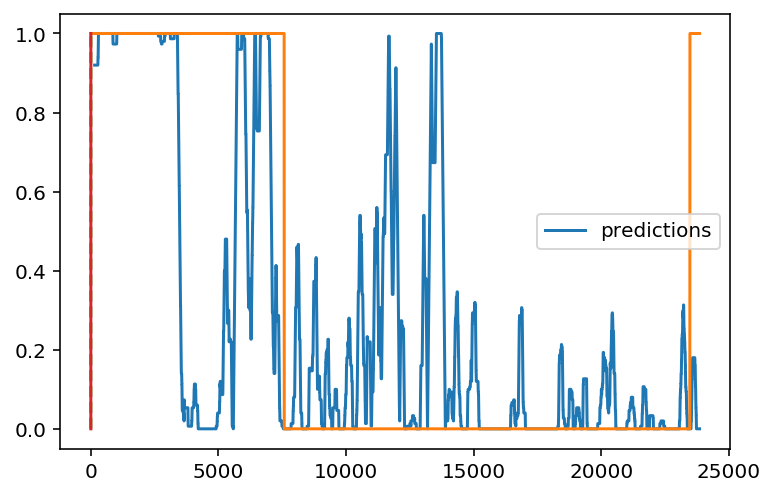


array([[13868,  2032],
       [ 3128,  4831]])
        HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy  \
0  0.33169  0.265095  0.179174  0.120233  0.103808        0.0  0.783729   

   true_negative  true_positive  false_positive  false_negative  
0          13868           4831            2032            3128  
TRAIN: [    0     1     2 ... 71578 71579 71580] TEST: [71581 71582 71583 ... 95437 95438 95439]


<Figure size 432x288 with 0 Axes>

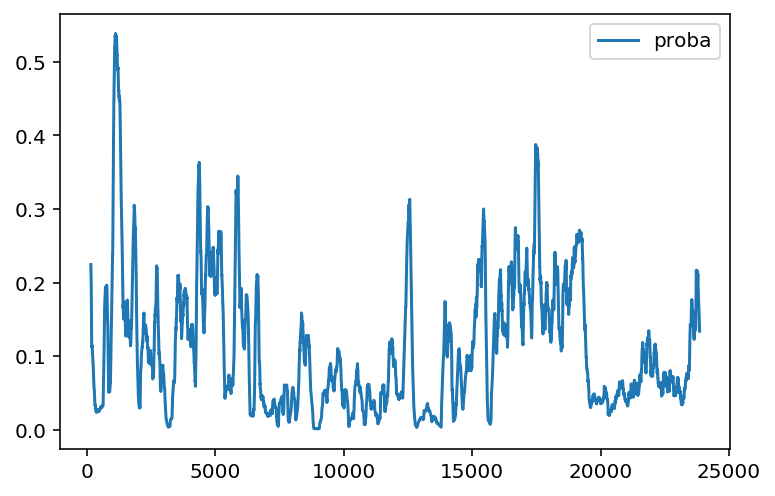

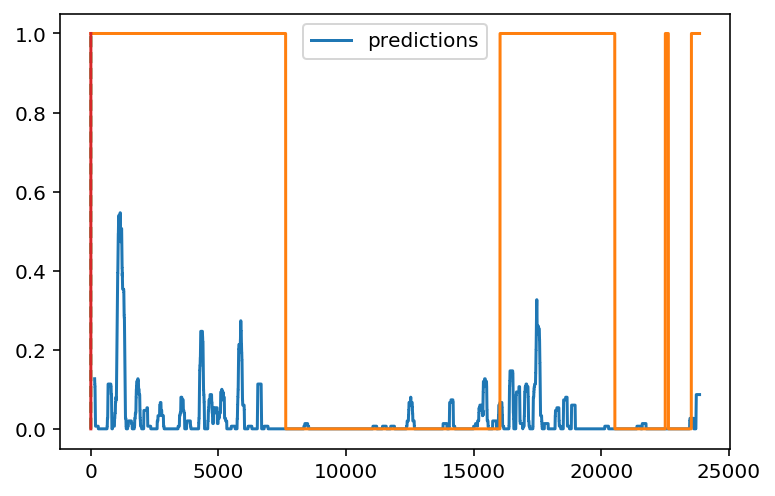


array([[11197,    81],
       [12058,   523]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy  \
0  0.372778  0.266405  0.158207  0.107732  0.094878        0.0  0.491219   

   true_negative  true_positive  false_positive  false_negative  
0          11197            523              81           12058  
TRAIN: [    0     1     2 ... 95437 95438 95439] TEST: [ 95440  95441  95442 ... 119296 119297 119298]


<Figure size 432x288 with 0 Axes>

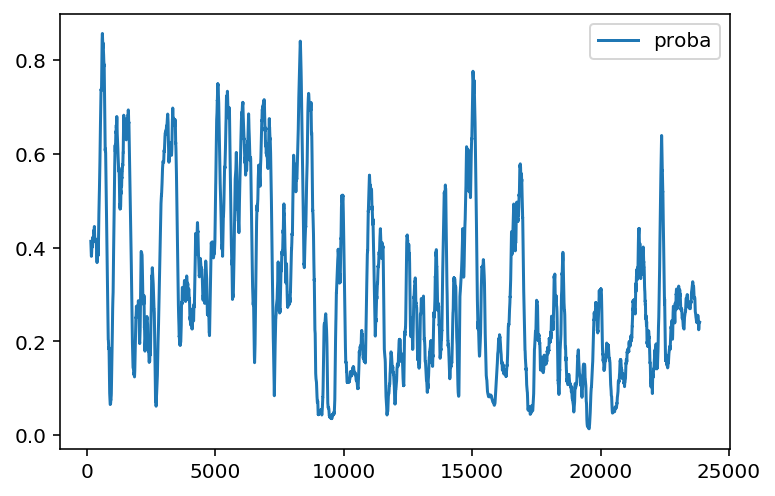

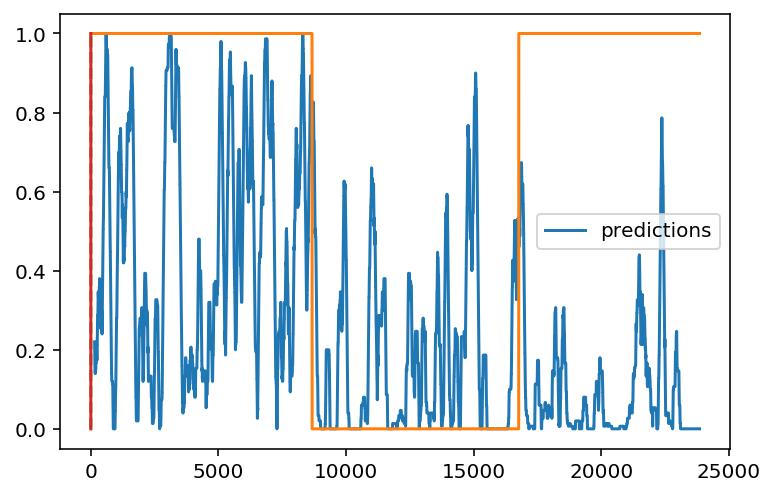


array([[ 6635,  1465],
       [11146,  4613]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy  \
0  0.343159  0.262956  0.172018  0.120373  0.101495        0.0  0.471436   

   true_negative  true_positive  false_positive  false_negative  
0           6635           4613            1465           11146  
TRAIN: [     0      1      2 ... 119296 119297 119298] TEST: [119299 119300 119301 ... 143155 143156 143157]


<Figure size 432x288 with 0 Axes>

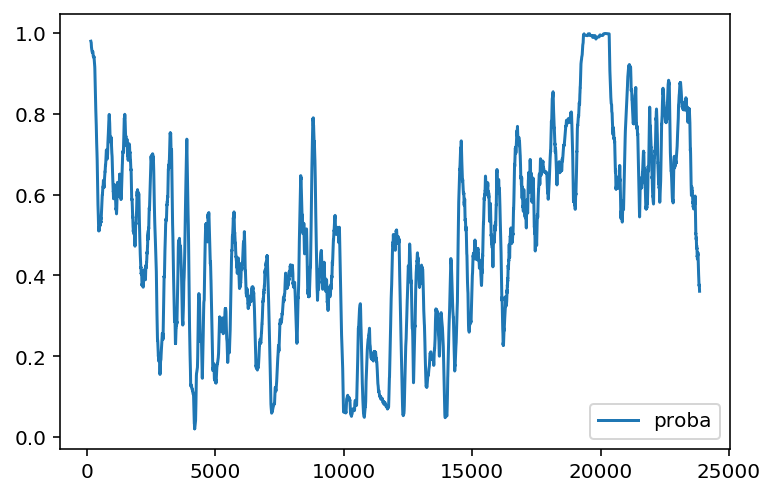

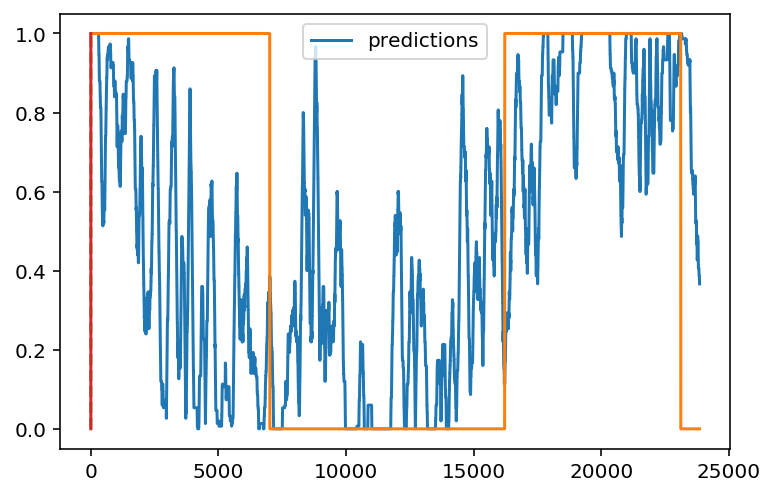


array([[7142, 2805],
       [5126, 8786]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy  \
0  0.319055  0.264467  0.180356  0.126926  0.109197        0.0  0.667589   

   true_negative  true_positive  false_positive  false_negative  
0           7142           8786            2805            5126  
CPU times: user 10min 54s, sys: 12.9 s, total: 11min 7s
Wall time: 3min 39s


In [35]:
%%time

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

Results=[]

p=Patient_Data(2)
p = p[p.BR<1000].dropna()

dummies=pd.get_dummies(pd.cut(p.glucose,[p.glucose.min(),4,8,p.glucose.max()],labels=['hypo','regular','hyper']))

dummies=dummies.shift(-300).dropna()
p=p.drop(p.tail(300).index)

p.drop(labels=['patientg','glucose', 'glucose_diff','patients','LinkQuality','CoreTemp','SystemConfidence','ECGNoise','StatusInfo',
        'ROGTime','HRConfidence','DeviceTemp','BatteryVolts','BatteryLevel','BRAmplitude','BRNoise','BRConfidence',
       'ECGAmplitude','HRV','GSR','ROGState','VerticalMin', 'VerticalPeak','LateralMin','LateralPeak','SagittalMin',
       'SagittalPeak','RSSI','TxPower','AuxADC1','AuxADC2','AuxADC3','bin_number'],axis=1,inplace=True)

X=p.values
X=pd.DataFrame(X).loc[:,:].ewm(com=0.9).mean().values
y=dummies.hyper.values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    # Feature Scaling
    from sklearn.preprocessing import QuantileTransformer
    sc = QuantileTransformer(n_quantiles=60, random_state=0)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # Fitting classifier to the Training set
    # Create your classifier here
    from sklearn.ensemble import RandomForestClassifier
    classifier1 = RandomForestClassifier(n_estimators = 500, criterion = 'entropy',n_jobs=6)
    classifier1.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = classifier1.predict(X_test)
    
    from sklearn.metrics import roc_auc_score,roc_curve
    from matplotlib import pyplot
    
    # predict probabilities
    probs = classifier1.predict_proba(X_test)
   
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)

    plt.figure()
    probability=pd.DataFrame(probs,columns=['proba']).rolling(window=150).mean()
    probability.plot()
    predictions=pd.DataFrame(y_pred,columns=['predictions']).rolling(window=150).mean()
    predictions.plot()
    y_test=pd.DataFrame(y_test,columns=['y_test'])
    plt.plot(y_test)
    
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr)
   
    # show the plot
    pyplot.show()

    #Feature Importance
    FI = pd.DataFrame(classifier1.feature_importances_).sort_values(by=0, ascending=False).T
    FI.columns=list(p.columns.values)

    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    scores=classifier1.score(X_test,y_test)
    FI['Accuracy']=scores
    FI['true_negative']=cm[0,0]
    FI['true_positive']=cm[1,1]
    FI['false_positive']=cm[0,1]
    FI['false_negative']=cm[1,0]
    import pprint
    print ('')
    pprint.pprint (cm)
    pprint.pprint(FI)

for i in range(0,len(FI.T)):
    Results.append((FI.iloc[0,i]))
    
score=pd.DataFrame([Results],columns=list(FI.columns))
        
score.to_csv('Model_Results.csv')

data_plot=pd.concat([probability,predictions,y_test],names=['probability','predictions','y_test'],axis=1)
data_plot.to_csv('data_plot.csv')


#### Part 3 - Section 2: General Model to check results across all patients

In [37]:
%%time
import warnings
warnings.filterwarnings("ignore")

Results=[]
score=pd.DataFrame()
for d_patient in tqdm([1,2,4,5,6,7,8]):
    
    p=Patient_Data(d_patient)
    p = p[p.BR<1000].dropna()

    dummies=pd.get_dummies(pd.cut(p.glucose,[p.glucose.min(),4,8,p.glucose.max()],labels=['hypo','regular','hyper']))

    dummies=dummies.shift(-300).dropna()
    p=p.drop(p.tail(300).index)

    p.drop(labels=['patientg','glucose', 'glucose_diff','patients','LinkQuality','CoreTemp','SystemConfidence','ECGNoise','StatusInfo',
            'ROGTime','HRConfidence','DeviceTemp','BatteryVolts','BatteryLevel','BRAmplitude','BRNoise','BRConfidence',
           'ECGAmplitude','HRV','GSR','ROGState','VerticalMin', 'VerticalPeak','LateralMin','LateralPeak','SagittalMin',
           'SagittalPeak','RSSI','TxPower','AuxADC1','AuxADC2','AuxADC3','bin_number'],axis=1,inplace=True)

    X=p.values
    X=pd.DataFrame(X).loc[:,:].ewm(com=0.9).mean().values
    y=dummies.hyper.values

    # Splitting the dataset into the Training set and Test set
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


        # Feature Scaling
        from sklearn.preprocessing import StandardScaler
        from sklearn.preprocessing import RobustScaler
        from sklearn.preprocessing import QuantileTransformer
 
        sc = QuantileTransformer(n_quantiles=60, random_state=0)
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)

        # Fitting classifier to the Training set
        # Create your classifier here
        from sklearn.ensemble import RandomForestClassifier
        classifier1 = RandomForestClassifier(n_estimators = 500, criterion = 'entropy',n_jobs=6)

        # from sklearn.linear_model import LogisticRegression

        classifier1.fit(X_train, y_train)

        # Predicting the Test set results
        y_pred = classifier1.predict(X_test)

        #Feature Importance
        FI = pd.DataFrame(classifier1.feature_importances_).sort_values(by=0, ascending=False).T
        FI.columns=list(p.columns.values)


        # Making the Confusion Matrix
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_test, y_pred)
        scores=classifier1.score(X_test,y_test)
        FI['Accuracy']=scores

        import pprint
        print ('')
        pprint.pprint (cm)
        pprint.pprint(FI)



    Results.append(FI.Accuracy.values)
    


  0%|          | 0/7 [00:00<?, ?it/s]

TRAIN: [    0     1     2 ... 20196 20197 20198] TEST: [20199 20200 20201 ... 40393 40394 40395]

array([[    0,     0],
       [ 3573, 16624]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.299956  0.282261  0.164809  0.139662  0.113312        0.0  0.823093
TRAIN: [    0     1     2 ... 40393 40394 40395] TEST: [40396 40397 40398 ... 60590 60591 60592]

array([[  572, 10595],
       [  289,  8741]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.314497  0.289443  0.160298  0.130198  0.105563        0.0  0.461108
TRAIN: [    0     1     2 ... 60590 60591 60592] TEST: [60593 60594 60595 ... 80787 80788 80789]

array([[ 1872,  3918],
       [ 2190, 12217]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.287893  0.229957  0.195237  0.151233   0.13568        0.0  0.697579
TRAIN: [    0     1     2 ... 80787 80788 80789] TEST: [ 80790  80791  80792 ... 100984 100985 100986]

array([[  304,  2483],



 14%|█▍        | 1/7 [03:36<21:41, 216.97s/it]


array([[ 2203, 17994],
       [    0,     0]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.264681  0.229384  0.203758  0.158692  0.143485        0.0  0.109076
TRAIN: [    0     1     2 ... 23860 23861 23862] TEST: [23863 23864 23865 ... 47719 47720 47721]

array([[9822, 2260],
       [9726, 2051]])
         HR       BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.292441  0.27572  0.204905  0.119727  0.107207        0.0  0.497632
TRAIN: [    0     1     2 ... 47719 47720 47721] TEST: [47722 47723 47724 ... 71578 71579 71580]

array([[13730,  2170],
       [ 3139,  4820]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.332362  0.265468  0.179444  0.120096   0.10263        0.0  0.777484
TRAIN: [    0     1     2 ... 71578 71579 71580] TEST: [71581 71582 71583 ... 95437 95438 95439]

array([[11197,    81],
       [12067,   514]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.371667 


 29%|██▊       | 2/7 [07:16<18:09, 217.82s/it]


array([[7162, 2785],
       [5127, 8785]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.319118  0.265354  0.178638  0.127199  0.109691        0.0  0.668385
TRAIN: [    0     1     2 ... 24791 24792 24793] TEST: [24794 24795 24796 ... 49583 49584 49585]

array([[5839, 9078],
       [3347, 6528]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.236168  0.231541  0.202344  0.165521  0.164426        0.0   0.49883
TRAIN: [    0     1     2 ... 49583 49584 49585] TEST: [49586 49587 49588 ... 74375 74376 74377]

array([[  767, 16329],
       [  127,  7569]])
        HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.29422  0.207869  0.207867  0.146419  0.143626        0.0  0.336237
TRAIN: [    0     1     2 ... 74375 74376 74377] TEST: [74378 74379 74380 ... 99167 99168 99169]

array([[3432, 2444],
       [8960, 9956]])
        HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.27399  0.215671 


 43%|████▎     | 3/7 [11:21<15:02, 225.74s/it]


array([[    0,     0],
       [ 9425, 15367]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.259923  0.217103  0.212629  0.159134  0.151211        0.0  0.619837
TRAIN: [    0     1     2 ... 27368 27369 27370] TEST: [27371 27372 27373 ... 54737 54738 54739]

array([[6760, 8469],
       [6504, 5636]])
        HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.26696  0.214822   0.19151  0.165504  0.161205        0.0  0.452921
TRAIN: [    0     1     2 ... 54737 54738 54739] TEST: [54740 54741 54742 ... 82106 82107 82108]

array([[ 4321,  3179],
       [12249,  7620]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.331425  0.204496  0.162296  0.155589  0.146194        0.0  0.436297
TRAIN: [    0     1     2 ... 82106 82107 82108] TEST: [ 82109  82110  82111 ... 109475 109476 109477]

array([[ 2345,  6955],
       [ 7945, 10124]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.3


 57%|█████▋    | 4/7 [15:44<11:51, 237.06s/it]


array([[ 2644, 16720],
       [ 1010,  6995]])
         HR       BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.298515  0.21321   0.17314  0.167404  0.147732        0.0  0.352187
TRAIN: [    0     1     2 ... 24410 24411 24412] TEST: [24413 24414 24415 ... 48818 48819 48820]

array([[  699, 21056],
       [    0,  2653]])
         HR       BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.330214  0.27695  0.163794  0.117591  0.111451        0.0  0.137332
TRAIN: [    0     1     2 ... 48818 48819 48820] TEST: [48821 48822 48823 ... 73226 73227 73228]

array([[ 5642,   585],
       [13652,  4529]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.316994  0.265917   0.17622  0.126485  0.114385        0.0  0.416708
TRAIN: [    0     1     2 ... 73226 73227 73228] TEST: [73229 73230 73231 ... 97634 97635 97636]

array([[4222, 6285],
       [5859, 8042]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.336046  0


 71%|███████▏  | 5/7 [19:32<07:48, 234.35s/it]


array([[ 5761, 18647],
       [    0,     0]])
       HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.2925  0.212131     0.212  0.148295  0.135073        0.0  0.236029
TRAIN: [    0     1     2 ... 33786 33787 33788] TEST: [33789 33790 33791 ... 67574 67575 67576]

array([[12714,  2880],
       [11730,  6464]])
        HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.34896  0.196087  0.184507  0.142426  0.128021        0.0  0.567598
TRAIN: [    0     1     2 ... 67574 67575 67576] TEST: [ 67577  67578  67579 ... 101362 101363 101364]

array([[10064,  5662],
       [10681,  7381]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.269789  0.244238  0.195837  0.150521  0.139614        0.0  0.516308
TRAIN: [     0      1      2 ... 101362 101363 101364] TEST: [101365 101366 101367 ... 135150 135151 135152]

array([[ 2289,  2278],
       [13961, 15260]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Acc


 86%|████████▌ | 6/7 [25:34<04:32, 272.67s/it]


array([[ 4373, 17415],
       [ 2359,  9641]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.246461  0.234732  0.197306  0.164427  0.157074        0.0  0.414763
TRAIN: [    0     1     2 ... 32212 32213 32214] TEST: [32215 32216 32217 ... 64426 64427 64428]

array([[27091,   636],
       [ 4444,    43]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.260232  0.216558  0.204467  0.163276  0.155467        0.0  0.842305
TRAIN: [    0     1     2 ... 64426 64427 64428] TEST: [64429 64430 64431 ... 96640 96641 96642]

array([[    0,     0],
       [31998,   216]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.318094  0.210985  0.175918  0.152781  0.142222        0.0  0.006705
TRAIN: [    0     1     2 ... 96640 96641 96642] TEST: [ 96643  96644  96645 ... 128854 128855 128856]

array([[ 2392,  8690],
       [ 8370, 12762]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy



100%|██████████| 7/7 [30:30<00:00, 279.60s/it]



array([[26597,  5617],
       [    0,     0]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.355242  0.196932   0.18904  0.141257  0.117529        0.0  0.825635
CPU times: user 1h 36min 56s, sys: 1min 29s, total: 1h 38min 26s
Wall time: 30min 30s
